# Simple Multi-Layer Perceptron

This code implement a multi-layer perceptron with two layers. 
In the first layer is used a ReLU activation function and in the second one the Softmax.
The cost is calculated using the Cross Entropy Loss. 


In [ ]:
import numpy as np

Definition of the class

In [361]:
class SimpleMultiLayerPerceptron:
    def __init__(self, max_iters=25, learning_rate=0.001, hidden_units=10, minibatch_size=10, regularization_rate=0.01):
        self.max_iters = max_iters
        self.learning_rate = learning_rate
        self.hidden_units = hidden_units
        self.minibatch_size = minibatch_size
        self.regularization_rate = regularization_rate
        self.size_image = 8

    '''
    Generator for mini-batch
    '''
    def iterate_minibatches(self, inputs, targets, batch_size, shuffle=False):
        assert inputs.shape[0] == targets.shape[0]  # input / output shape

        if shuffle: # batch shuffle
            indices = np.arange(inputs.shape[0])
            np.random.shuffle(indices)

        for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batch_size]
            else:
                excerpt = slice(start_idx, start_idx + batch_size)

            yield inputs[excerpt], targets[excerpt]
    
    '''
    ReLu (Rectified Linear Unit) function
    '''
    def relu_function(self, matrix_content, matrix_dim_x, matrix_dim_y):
        ret_vector = np.zeros((matrix_dim_x, matrix_dim_y))

        for i in range(matrix_dim_x):
            for j in range(matrix_dim_y):
                ret_vector[i, j] = max(0, matrix_content[i,j])

        return ret_vector

    '''
    Softmax Function
    '''
    def softmax_function(self, vector_content):
        return np.exp(vector_content - np.max(vector_content)) / np.sum(np.exp(vector_content - np.max(vector_content)), axis=0)
    
    '''
    The derivate of ReLu (Rectified Linear Unit) function.
    This function return 1 where the value is > 0 and 0 when the value is <= 0
    '''
    def derivate_of_relu(self, matrix_content, matrix_dim_x, matrix_dim_y):
        ret_vector = np.zeros((matrix_dim_x, matrix_dim_y))

        for i in range(matrix_dim_x):
            for j in range(matrix_dim_y):
                if matrix_content[i, j] > 0:
                    ret_vector[i, j] = 1
                else:
                    ret_vector[i, j] = 0

        return ret_vector

    '''
    yHat represents the predicted value / probability value calculated as output of hypothesis / sigmoid function
    y represents the actual label
    '''
    def cross_entropy_loss(self, yHat, y):
        cost = 0
        for i in range(y.shape[1]):
            y_line = y[:,i].T
            yHat_line = yHat[:,i]
            cost -= (1.0/y.shape[0]) * np.sum(y_line*np.log(yHat_line) + (1-y_line)*np.log(1-yHat_line))
        return cost/y.shape[1]
    

    '''
    Stochastic Gradient Descent.
    The input is the size of the image (self.size_image x self.size_image). 
    The output is the number of the calsses (0 .. 9) = 10 classes. 
    '''
    def fit(self, X, y):
        # parameter initialize
        # Matrix with weights for the hidden layer
        w1_mat = np.random.randn(self.hidden_units, self.size_image*self.size_image) * np.sqrt(2.0/(self.hidden_units + self.size_image*self.size_image))
        # Matrix with weights for the output layer
        w2_mat = np.random.randn(10, self.hidden_units) * np.sqrt(2./(10 + self.hidden_units))

        # Vector with the bias for the hidden layer
        b1_vec = np.zeros((self.hidden_units, 1))
        # Vector with the bias for the output layer 
        b2_vec = np.zeros((10, 1))

        # input / output size reshape
        X = np.reshape(X, (X.shape[0], self.size_image*self.size_image))
        y = np.reshape(y, (y.shape[0], 1))

        self.errors_ = []

        for nr_iters in range(self.max_iters) :
            if nr_iters % 10 == 0:
                print("Current epoch number : ", nr_iters)
            error = 0
            ct = 0
            for batch in self.iterate_minibatches(X, y, self.minibatch_size, shuffle=True):
                x_batch, y_batch = batch
                x_batch = x_batch.T
                y_batch = y_batch.T

                # Forward phase
                # For the Hidden Layer get z1 = Input x weights + Bias
                z1 = np.dot(w1_mat, x_batch) + b1_vec
                # Apply ReLU activation function to z 
                a1 = self.relu_function(z1, self.hidden_units, self.minibatch_size)

                # for the output layer get z2 = output hidden layer (a2) x weights + Bias   
                z2 = np.dot(w2_mat, a1) + b2_vec
                # Apply Softmax activation function to z2
                a2_softmax = self.softmax_function(z2)

                # Apply the cross-entropy for loss function
                # gt_vector (ground truth vector) has 10 lines for the possible output (1..10) each colum is an observation
                gt_vector = np.zeros((10, self.minibatch_size))
                for example_num in range(self.minibatch_size):
                    gt_vector[y_batch[0, example_num], example_num] = 1


                # Regularization for weights
                # initialize the deltas to sum to the weights with a factor based on the 
                # regularization rate and the current value of the weights 
                d_w2_mat = self.regularization_rate*w2_mat
                d_w1_mat = self.regularization_rate*w1_mat

                # Backward phase 
                # Get difference between predicted (a2_softmax) and the actual value (gt_vector)
                delta_2 = np.array(a2_softmax - gt_vector)

                # Get the new values of the delta to sum to the weights of the output layer by multiplying the 
                # output of the hidden layer by the delta and add to the previous value of the weights
                d_w2_mat = d_w2_mat + np.dot(delta_2, (np.matrix(a1)).T)

                # Get the new values of delta to sum to the bias of the output layer by adding the delta to the previous bias value
                d_b2_vec = np.sum(delta_2, axis=1, keepdims=True)

                # Now to calculate the delta_1 it's necessary to propagate the delta_2 to the hidden layer
                # it's depends on the derivate of the output of hidden layer that is a ReLU function. 
                delta_1 = np.array(np.multiply(np.dot(w2_mat.T, delta_2), 
                                               self.derivate_of_relu(z1, self.hidden_units, self.minibatch_size)))
                
                # Calculate the weights and bias deltas
                d_w1_mat = d_w1_mat + np.dot(delta_1, np.matrix(x_batch).T)
                d_b1_vec = np.sum(delta_1, axis=1, keepdims=True)

                d_w2_mat = d_w2_mat/self.minibatch_size
                d_w1_mat = d_w1_mat/self.minibatch_size
                d_b2_vec = d_b2_vec/self.minibatch_size
                d_b1_vec = d_b1_vec/self.minibatch_size

                # update weights and bias
                w2_mat = w2_mat - self.learning_rate*d_w2_mat
                b2_vec = b2_vec - self.learning_rate*d_b2_vec

                w1_mat = w1_mat - self.learning_rate*d_w1_mat
                b1_vec = b1_vec - self.learning_rate*d_b1_vec

                # Get the error using cross entropy loss cost function
                error  += self.cross_entropy_loss(a2_softmax, gt_vector) 
                ct += 1

            self.errors_.append(error/(ct))
        self.w1_mat, self.b1_vec, self.w2_mat, self.b2_vec = w1_mat, b1_vec, w2_mat, b2_vec

    '''
    Predict a result.
    '''
    def predict(self, X):
        num_examples = X.shape[0]
        output_labels = np.zeros(X.shape[0])

        X = np.reshape(X, (num_examples, self.size_image*self.size_image))
        X = X.T

        z1 = np.dot(self.w1_mat, X) + self.b1_vec    
        a1 = self.relu_function(z1, self.hidden_units, num_examples)

        z2 = np.dot(self.w2_mat, a1) + self.b2_vec
        a2_softmax = self.softmax_function(z2)

        for i in range(num_examples):
            pred_col = a2_softmax[:, [i]]
            output_labels[i] = np.argmax(pred_col)
            
        return output_labels           


Train and test our implementation using the MNIST dataset from sklearn (images with 8x8)

In [374]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

#
# Create training and test split
#
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.3, shuffle=False)

smlp = SimpleMultiLayerPerceptron(max_iters=40, learning_rate=0.01, hidden_units=50, minibatch_size=100, regularization_rate=0.001)

print (X_train.shape)

smlp.fit(X_train, y_train)

y_predited = smlp.predict(X_test)

print('Predicted value:', y_predited[:20])
print('Actual Value:', y_test[:20])



(1257, 64)
Current epoch number :  0
Current epoch number :  10
Current epoch number :  20
Current epoch number :  30
Predicted value: [4. 0. 5. 3. 6. 9. 6. 6. 7. 5. 4. 4. 7. 2. 8. 2. 2. 5. 7. 9.]
Actual Value: [4 0 5 3 6 9 6 1 7 5 4 4 7 2 8 2 2 5 7 9]


Plot the performance of teh model during the tain.

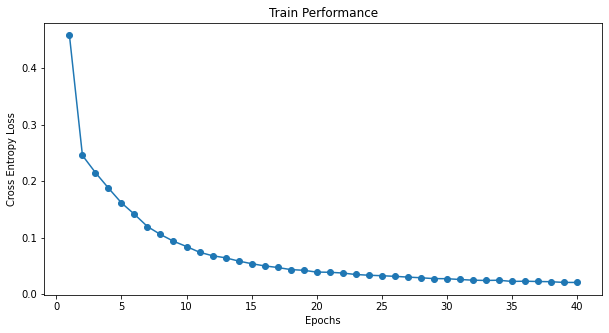

In [367]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
 
plt.plot(range(1, len(smlp.errors_) + 1), smlp.errors_, marker='o')
plt.title("Train Performance")


plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
 
plt.show()